In [1]:
#!pip install geoplot
#!pip install contextily
#!pip install altair

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import geopandas as gpd 
import nltk
nltk.download('punkt')
#import contextily as ctx
#import geoplot as gplt
#import geoplot.crs as gcrs
#import folium
#import seaborn as sns
#import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [3]:

df = pd.read_csv("https://data.enseignementsup-recherche.gouv.fr//explore/dataset/fr_crous_logement_france_entiere/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false", 
                 sep =';')


In [4]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [5]:
from functions_for_data_cleaning_file_modelling import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Vincent Fayo,Description Résidence universitaire située à p...,75 rue Vincent Fayo 92290 Châtenay-Malabry,"48.762802124,2.2827095985",Île-de-France,[156.0],156.00,156.00,156.000000,[],NaN,NaN,NaN,2.282710,48.762802,POINT (2.28271 48.76280)
1,Résidence Saints-Sauveurs,Description Résidence universitaire située au ...,15 rue des Saints sauveurs 92260 Fontenay-aux-...,"48.7911109924,2.2972493172",Île-de-France,"[322.0, 537.0]",537.00,322.00,429.500000,"[14.5, 24.0]",24.0,14.5,19.250000,2.297249,48.791111,POINT (2.29725 48.79111)
2,Résidence Le Vieux Pozzo,Description Résidence universitaire située dan...,2 avenue Pozzo di Borgo 92210 Saint-Cloud,"48.8452682495,2.2163643837",Île-de-France,[421.0],421.00,421.00,421.000000,[],NaN,NaN,NaN,2.216364,48.845268,POINT (2.21636 48.84527)
3,Résidence Flora Tristan,Description Résidence universitaire située au ...,1 rue Jules Vallès 91000 Evry,"48.635974884,2.430277586",Île-de-France,"[242.0, 468.0]",468.00,242.00,355.000000,[],NaN,NaN,NaN,2.430278,48.635975,POINT (2.43028 48.63597)
4,Résidence Le Dragueur,Description Résidence universitaire située au ...,4 allée Jean-Rostand 91000 Evry,"48.6271018982,2.4313938618",Île-de-France,"[349.0, 451.0]",451.00,349.00,400.000000,[],NaN,NaN,NaN,2.431394,48.627102,POINT (2.43139 48.62710)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence Sylvabelle,Résidence destinée aux enseignants chercheur...,109 rue Sylvabelle - 13006 Marseille,"43.2881393433,5.3745207787",Provence-Alpes-Côte d'Azur,[],NaN,NaN,NaN,[],NaN,NaN,NaN,5.374521,43.288139,POINT (5.37452 43.28814)
791,Résidence La Garidelle,"33 T1 de 18 à 34m² de 258,48 à 378,51 euros - ...",10 rue Saint Bernard – 84000 Avignon,"43.9507484436,4.818210125",Provence-Alpes-Côte d'Azur,"[258.48, 378.51, 404.55, 630.15]",630.15,258.48,417.922500,"[18.0, 34.0, 31.0, 59.0]",59.0,18.0,35.500000,4.818210,43.950748,POINT (4.81821 43.95075)
792,Cité universitaire Les Gazelles,7 pavillons au calme dans un cadre agréableme...,31 avenue Jules Ferry - 13090 Aix-en-Provence,"43.5189285278,5.4498591423",Provence-Alpes-Côte d'Azur,"[285.5, 285.5, 367.5, 285.5, 236.5, 255.5, 367...",367.50,236.50,302.681818,"[14.0, 14.0, 20.0, 14.0, 14.0, 9.0, 20.0, 9.0,...",20.0,9.0,14.818182,5.449859,43.518929,POINT (5.44986 43.51893)
793,Résidence Nautilus,"10 T2 à 318,37 € - Dépôt de garantie : 165 eu...",Rue Jules Verne - Encagnane - 13090 Aix-en-Pro...,"43.5210456848,5.4311909676",Provence-Alpes-Côte d'Azur,"[318.37, 376.97]",376.97,318.37,347.670000,[],NaN,NaN,NaN,5.431191,43.521046,POINT (5.43119 43.52105)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [6]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [7]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [8]:
df_private.rename(columns = {'INSEE':'codgeo'}, inplace = True)

In [9]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
for i in range(0,df_private.shape[0]):
    if  len(df_private["codgeo"][i]) == 4: 
            df_private["codgeo"][i] = "0" +  df_private["codgeo"][i]

In [10]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [11]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


On ne garde que le code INSEE et les données polygoniales. 

In [12]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [13]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [14]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_559/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [15]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2
0,Résidence Vincent Fayo,Description Résidence universitaire située à p...,75 rue Vincent Fayo 92290 Châtenay-Malabry,"48.762802124,2.2827095985",Île-de-France,[156.0],156.00,156.00,156.000000,[],NaN,NaN,NaN,2.282710,48.762802,POINT (2.28271 48.76280),Châtenay-Malabry,"23,3514485"
1,Résidence Saints-Sauveurs,Description Résidence universitaire située au ...,15 rue des Saints sauveurs 92260 Fontenay-aux-...,"48.7911109924,2.2972493172",Île-de-France,"[322.0, 537.0]",537.00,322.00,429.500000,"[14.5, 24.0]",24.0,14.5,19.250000,2.297249,48.791111,POINT (2.29725 48.79111),Fontenay-aux-Roses,"23,11203179"
2,Résidence Le Vieux Pozzo,Description Résidence universitaire située dan...,2 avenue Pozzo di Borgo 92210 Saint-Cloud,"48.8452682495,2.2163643837",Île-de-France,[421.0],421.00,421.00,421.000000,[],NaN,NaN,NaN,2.216364,48.845268,POINT (2.21636 48.84527),Saint-Cloud,"29,82018866"
3,Résidence Flora Tristan,Description Résidence universitaire située au ...,1 rue Jules Vallès 91000 Evry,"48.635974884,2.430277586",Île-de-France,"[242.0, 468.0]",468.00,242.00,355.000000,[],NaN,NaN,NaN,2.430278,48.635975,POINT (2.43028 48.63597),Évry,"19,90273608"
4,Résidence Le Dragueur,Description Résidence universitaire située au ...,4 allée Jean-Rostand 91000 Evry,"48.6271018982,2.4313938618",Île-de-France,"[349.0, 451.0]",451.00,349.00,400.000000,[],NaN,NaN,NaN,2.431394,48.627102,POINT (2.43139 48.62710),Évry,"19,90273608"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence Sylvabelle,Résidence destinée aux enseignants chercheur...,109 rue Sylvabelle - 13006 Marseille,"43.2881393433,5.3745207787",Provence-Alpes-Côte d'Azur,[],NaN,NaN,NaN,[],NaN,NaN,NaN,5.374521,43.288139,POINT (5.37452 43.28814),Marseille 6e Arrondissement,"17,6067511"
791,Résidence La Garidelle,"33 T1 de 18 à 34m² de 258,48 à 378,51 euros - ...",10 rue Saint Bernard – 84000 Avignon,"43.9507484436,4.818210125",Provence-Alpes-Côte d'Azur,"[258.48, 378.51, 404.55, 630.15]",630.15,258.48,417.922500,"[18.0, 34.0, 31.0, 59.0]",59.0,18.0,35.500000,4.818210,43.950748,POINT (4.81821 43.95075),Avignon,"14,31536249"
792,Cité universitaire Les Gazelles,7 pavillons au calme dans un cadre agréableme...,31 avenue Jules Ferry - 13090 Aix-en-Provence,"43.5189285278,5.4498591423",Provence-Alpes-Côte d'Azur,"[285.5, 285.5, 367.5, 285.5, 236.5, 255.5, 367...",367.50,236.50,302.681818,"[14.0, 14.0, 20.0, 14.0, 14.0, 9.0, 20.0, 9.0,...",20.0,9.0,14.818182,5.449859,43.518929,POINT (5.44986 43.51893),Aix-en-Provence,"20,962383"
793,Résidence Nautilus,"10 T2 à 318,37 € - Dépôt de garantie : 165 eu...",Rue Jules Verne - Encagnane - 13090 Aix-en-Pro...,"43.5210456848,5.4311909676",Provence-Alpes-Côte d'Azur,"[318.37, 376.97]",376.97,318.37,347.670000,[],NaN,NaN,NaN,5.431191,43.521046,POINT (5.43119 43.52105),Aix-en-Provence,"20,962383"


## 1.4 Ajout des départements 

In [16]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [17]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_559/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [18]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,index_right,departement
0,Résidence Vincent Fayo,Description Résidence universitaire située à p...,75 rue Vincent Fayo 92290 Châtenay-Malabry,"48.762802124,2.2827095985",Île-de-France,[156.0],156.00,156.00,156.000000,[],NaN,NaN,NaN,2.282710,48.762802,POINT (2.28271 48.76280),Châtenay-Malabry,"23,3514485",35,Hauts-de-Seine
1,Résidence Saints-Sauveurs,Description Résidence universitaire située au ...,15 rue des Saints sauveurs 92260 Fontenay-aux-...,"48.7911109924,2.2972493172",Île-de-France,"[322.0, 537.0]",537.00,322.00,429.500000,"[14.5, 24.0]",24.0,14.5,19.250000,2.297249,48.791111,POINT (2.29725 48.79111),Fontenay-aux-Roses,"23,11203179",35,Hauts-de-Seine
2,Résidence Le Vieux Pozzo,Description Résidence universitaire située dan...,2 avenue Pozzo di Borgo 92210 Saint-Cloud,"48.8452682495,2.2163643837",Île-de-France,[421.0],421.00,421.00,421.000000,[],NaN,NaN,NaN,2.216364,48.845268,POINT (2.21636 48.84527),Saint-Cloud,"29,82018866",35,Hauts-de-Seine
3,Résidence Flora Tristan,Description Résidence universitaire située au ...,1 rue Jules Vallès 91000 Evry,"48.635974884,2.430277586",Île-de-France,"[242.0, 468.0]",468.00,242.00,355.000000,[],NaN,NaN,NaN,2.430278,48.635975,POINT (2.43028 48.63597),Évry,"19,90273608",8,Essonne
4,Résidence Le Dragueur,Description Résidence universitaire située au ...,4 allée Jean-Rostand 91000 Evry,"48.6271018982,2.4313938618",Île-de-France,"[349.0, 451.0]",451.00,349.00,400.000000,[],NaN,NaN,NaN,2.431394,48.627102,POINT (2.43139 48.62710),Évry,"19,90273608",8,Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence Sylvabelle,Résidence destinée aux enseignants chercheur...,109 rue Sylvabelle - 13006 Marseille,"43.2881393433,5.3745207787",Provence-Alpes-Côte d'Azur,[],NaN,NaN,NaN,[],NaN,NaN,NaN,5.374521,43.288139,POINT (5.37452 43.28814),Marseille 6e Arrondissement,"17,6067511",3,Bouches-du-Rhône
791,Résidence La Garidelle,"33 T1 de 18 à 34m² de 258,48 à 378,51 euros - ...",10 rue Saint Bernard – 84000 Avignon,"43.9507484436,4.818210125",Provence-Alpes-Côte d'Azur,"[258.48, 378.51, 404.55, 630.15]",630.15,258.48,417.922500,"[18.0, 34.0, 31.0, 59.0]",59.0,18.0,35.500000,4.818210,43.950748,POINT (4.81821 43.95075),Avignon,"14,31536249",94,Vaucluse
792,Cité universitaire Les Gazelles,7 pavillons au calme dans un cadre agréableme...,31 avenue Jules Ferry - 13090 Aix-en-Provence,"43.5189285278,5.4498591423",Provence-Alpes-Côte d'Azur,"[285.5, 285.5, 367.5, 285.5, 236.5, 255.5, 367...",367.50,236.50,302.681818,"[14.0, 14.0, 20.0, 14.0, 14.0, 9.0, 20.0, 9.0,...",20.0,9.0,14.818182,5.449859,43.518929,POINT (5.44986 43.51893),Aix-en-Provence,"20,962383",3,Bouches-du-Rhône
793,Résidence Nautilus,"10 T2 à 318,37 € - Dépôt de garantie : 165 eu...",Rue Jules Verne - Encagnane - 13090 Aix-en-Pro...,"43.5210456848,5.4311909676",Provence-Alpes-Côte d'Azur,"[318.37, 376.97]",376.97,318.37,347.670000,[],NaN,NaN,NaN,5.431191,43.521046,POINT (5.43119 43.52105),Aix-en-Provence,"20,962383",3,Bouches-du-Rhône


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Vincent Fayo,Description Résidence universitaire située à p...,75 rue Vincent Fayo 92290 Châtenay-Malabry,"48.762802124,2.2827095985",Île-de-France,[156.0],156.00,156.00,156.000000,[],NaN,NaN,NaN,2.282710,48.762802,POINT (2.28271 48.76280),Châtenay-Malabry,"23,3514485",Hauts-de-Seine
1,Résidence Saints-Sauveurs,Description Résidence universitaire située au ...,15 rue des Saints sauveurs 92260 Fontenay-aux-...,"48.7911109924,2.2972493172",Île-de-France,"[322.0, 537.0]",537.00,322.00,429.500000,"[14.5, 24.0]",24.0,14.5,19.250000,2.297249,48.791111,POINT (2.29725 48.79111),Fontenay-aux-Roses,"23,11203179",Hauts-de-Seine
2,Résidence Le Vieux Pozzo,Description Résidence universitaire située dan...,2 avenue Pozzo di Borgo 92210 Saint-Cloud,"48.8452682495,2.2163643837",Île-de-France,[421.0],421.00,421.00,421.000000,[],NaN,NaN,NaN,2.216364,48.845268,POINT (2.21636 48.84527),Saint-Cloud,"29,82018866",Hauts-de-Seine
3,Résidence Flora Tristan,Description Résidence universitaire située au ...,1 rue Jules Vallès 91000 Evry,"48.635974884,2.430277586",Île-de-France,"[242.0, 468.0]",468.00,242.00,355.000000,[],NaN,NaN,NaN,2.430278,48.635975,POINT (2.43028 48.63597),Évry,"19,90273608",Essonne
4,Résidence Le Dragueur,Description Résidence universitaire située au ...,4 allée Jean-Rostand 91000 Evry,"48.6271018982,2.4313938618",Île-de-France,"[349.0, 451.0]",451.00,349.00,400.000000,[],NaN,NaN,NaN,2.431394,48.627102,POINT (2.43139 48.62710),Évry,"19,90273608",Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence Sylvabelle,Résidence destinée aux enseignants chercheur...,109 rue Sylvabelle - 13006 Marseille,"43.2881393433,5.3745207787",Provence-Alpes-Côte d'Azur,[],NaN,NaN,NaN,[],NaN,NaN,NaN,5.374521,43.288139,POINT (5.37452 43.28814),Marseille 6e Arrondissement,"17,6067511",Bouches-du-Rhône
791,Résidence La Garidelle,"33 T1 de 18 à 34m² de 258,48 à 378,51 euros - ...",10 rue Saint Bernard – 84000 Avignon,"43.9507484436,4.818210125",Provence-Alpes-Côte d'Azur,"[258.48, 378.51, 404.55, 630.15]",630.15,258.48,417.922500,"[18.0, 34.0, 31.0, 59.0]",59.0,18.0,35.500000,4.818210,43.950748,POINT (4.81821 43.95075),Avignon,"14,31536249",Vaucluse
792,Cité universitaire Les Gazelles,7 pavillons au calme dans un cadre agréableme...,31 avenue Jules Ferry - 13090 Aix-en-Provence,"43.5189285278,5.4498591423",Provence-Alpes-Côte d'Azur,"[285.5, 285.5, 367.5, 285.5, 236.5, 255.5, 367...",367.50,236.50,302.681818,"[14.0, 14.0, 20.0, 14.0, 14.0, 9.0, 20.0, 9.0,...",20.0,9.0,14.818182,5.449859,43.518929,POINT (5.44986 43.51893),Aix-en-Provence,"20,962383",Bouches-du-Rhône
793,Résidence Nautilus,"10 T2 à 318,37 € - Dépôt de garantie : 165 eu...",Rue Jules Verne - Encagnane - 13090 Aix-en-Pro...,"43.5210456848,5.4311909676",Provence-Alpes-Côte d'Azur,"[318.37, 376.97]",376.97,318.37,347.670000,[],NaN,NaN,NaN,5.431191,43.521046,POINT (5.43119 43.52105),Aix-en-Provence,"20,962383",Bouches-du-Rhône


## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Calcul d'un cercle de 20 km autour de la résidence
"""
df1 = df
df1 = df1.to_crs(epsg = 3395) #On prend une projection en mètres
df1['geometry'] = df1['geometry'].buffer(20000) #On prend un rayon de 20km 
df1 = df1.to_crs(4326) #on repasse dans la projection uselle 
df1

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Vincent Fayo,Description Résidence universitaire située à p...,75 rue Vincent Fayo 92290 Châtenay-Malabry,"48.762802124,2.2827095985",Île-de-France,[156.0],156.00,156.00,156.000000,[],NaN,NaN,NaN,2.282710,48.762802,"POLYGON ((2.46237 48.76280, 2.46151 48.75116, ...",Châtenay-Malabry,"23,3514485",Hauts-de-Seine
1,Résidence Saints-Sauveurs,Description Résidence universitaire située au ...,15 rue des Saints sauveurs 92260 Fontenay-aux-...,"48.7911109924,2.2972493172",Île-de-France,"[322.0, 537.0]",537.00,322.00,429.500000,"[14.5, 24.0]",24.0,14.5,19.250000,2.297249,48.791111,"POLYGON ((2.47691 48.79111, 2.47605 48.77947, ...",Fontenay-aux-Roses,"23,11203179",Hauts-de-Seine
2,Résidence Le Vieux Pozzo,Description Résidence universitaire située dan...,2 avenue Pozzo di Borgo 92210 Saint-Cloud,"48.8452682495,2.2163643837",Île-de-France,[421.0],421.00,421.00,421.000000,[],NaN,NaN,NaN,2.216364,48.845268,"POLYGON ((2.39603 48.84527, 2.39516 48.83364, ...",Saint-Cloud,"29,82018866",Hauts-de-Seine
3,Résidence Flora Tristan,Description Résidence universitaire située au ...,1 rue Jules Vallès 91000 Evry,"48.635974884,2.430277586",Île-de-France,"[242.0, 468.0]",468.00,242.00,355.000000,[],NaN,NaN,NaN,2.430278,48.635975,"POLYGON ((2.60994 48.63597, 2.60908 48.62430, ...",Évry,"19,90273608",Essonne
4,Résidence Le Dragueur,Description Résidence universitaire située au ...,4 allée Jean-Rostand 91000 Evry,"48.6271018982,2.4313938618",Île-de-France,"[349.0, 451.0]",451.00,349.00,400.000000,[],NaN,NaN,NaN,2.431394,48.627102,"POLYGON ((2.61106 48.62710, 2.61019 48.61543, ...",Évry,"19,90273608",Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence Sylvabelle,Résidence destinée aux enseignants chercheur...,109 rue Sylvabelle - 13006 Marseille,"43.2881393433,5.3745207787",Provence-Alpes-Côte d'Azur,[],NaN,NaN,NaN,[],NaN,NaN,NaN,5.374521,43.288139,"POLYGON ((5.55418 43.28814, 5.55332 43.27527, ...",Marseille 6e Arrondissement,"17,6067511",Bouches-du-Rhône
791,Résidence La Garidelle,"33 T1 de 18 à 34m² de 258,48 à 378,51 euros - ...",10 rue Saint Bernard – 84000 Avignon,"43.9507484436,4.818210125",Provence-Alpes-Côte d'Azur,"[258.48, 378.51, 404.55, 630.15]",630.15,258.48,417.922500,"[18.0, 34.0, 31.0, 59.0]",59.0,18.0,35.500000,4.818210,43.950748,"POLYGON ((4.99787 43.95075, 4.99701 43.93802, ...",Avignon,"14,31536249",Vaucluse
792,Cité universitaire Les Gazelles,7 pavillons au calme dans un cadre agréableme...,31 avenue Jules Ferry - 13090 Aix-en-Provence,"43.5189285278,5.4498591423",Provence-Alpes-Côte d'Azur,"[285.5, 285.5, 367.5, 285.5, 236.5, 255.5, 367...",367.50,236.50,302.681818,"[14.0, 14.0, 20.0, 14.0, 14.0, 9.0, 20.0, 9.0,...",20.0,9.0,14.818182,5.449859,43.518929,"POLYGON ((5.62952 43.51893, 5.62866 43.50611, ...",Aix-en-Provence,"20,962383",Bouches-du-Rhône
793,Résidence Nautilus,"10 T2 à 318,37 € - Dépôt de garantie : 165 eu...",Rue Jules Verne - Encagnane - 13090 Aix-en-Pro...,"43.5210456848,5.4311909676",Provence-Alpes-Côte d'Azur,"[318.37, 376.97]",376.97,318.37,347.670000,[],NaN,NaN,NaN,5.431191,43.521046,"POLYGON ((5.61085 43.52105, 5.60999 43.50823, ...",Aix-en-Provence,"20,962383",Bouches-du-Rhône


In [22]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [23]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]

In [24]:
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_code_commune,etablissement_commune
427,Université de Strasbourg,54534,67482,Strasbourg
428,Université Toulouse Capitole,17867,31555,Toulouse
429,École nationale supérieure des sciences de l'i...,234,69266,Villeurbanne
430,Université Paris 1 - Panthéon Sorbonne,40413,75105,Paris 5e
431,Université Jean Moulin - Lyon 3,25559,69387,Lyon 7e
...,...,...,...,...
2283,École nationale supérieure de l'électronique e...,874,95127,Cergy
2284,Université Paris-Est Créteil,39198,94028,Créteil
2285,Aix-Marseille Université,71711,13207,Marseille 7e
2286,École nationale supérieure des arts et techniq...,216,69385,Lyon 5e


In [25]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [26]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes

/tmp/ipykernel_559/123655656.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes


In [27]:
df_schools.set_index('codgeo', inplace = True)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune
codgeo,,,
67482,Université de Strasbourg,54534,Strasbourg
31555,Université Toulouse Capitole,17867,Toulouse
69266,École nationale supérieure des sciences de l'i...,234,Villeurbanne
75105,Université Paris 1 - Panthéon Sorbonne,40413,Paris 5e
69387,Université Jean Moulin - Lyon 3,25559,Lyon 7e
...,...,...,...
95127,École nationale supérieure de l'électronique e...,874,Cergy
94028,Université Paris-Est Créteil,39198,Créteil
13207,Aix-Marseille Université,71711,Marseille 7e


In [28]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune,geometry
codgeo,,,,
06088,Université Côte d'Azur,33537,Nice,"POLYGON ((7.32125 43.72359, 7.32113 43.72360, ..."
10387,Université de technologie de Troyes,3235,Troyes,"POLYGON ((4.05058 48.29937, 4.05137 48.29921, ..."
13001,Sciences Po Aix,1682,Aix-en-Provence,"POLYGON ((5.50459 43.53231, 5.50421 43.53234, ..."
13207,Aix-Marseille Université,71711,Marseille 7e,"MULTIPOLYGON (((5.28590 43.26396, 5.28588 43.2..."
13213,Centrale Marseille,1165,Marseille 13e,"POLYGON ((5.41084 43.31492, 5.41150 43.31484, ..."
...,...,...,...,...
97302,Université de Guyane,3890,Cayenne,"MULTIPOLYGON (((-52.16862 4.88872, -52.16870 4..."
97411,Université de La Réunion,17044,Saint-Denis,"POLYGON ((55.46906 -21.00973, 55.47105 -21.008..."
97607,Centre universitaire de Mayotte,1335,Dembeni,"POLYGON ((45.16908 -12.88110, 45.17800 -12.886..."


In [29]:
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [30]:
"""
essai sur la résidence de Cergy 
"""
a = df_schools.within(df1["geometry"][1])
i = 0 
for element in a : 
    if element == True: 
        print(df_schools['etablissement_lib'][i])
    i = i + 1

Université Paris Lumières
Université Paris 1 - Panthéon Sorbonne
Université Sorbonne Nouvelle - Paris 3
IAE Paris - Sorbonne Business School
Université Paris-Panthéon-Assas
Muséum national d'histoire naturelle
Sorbonne Université
Université Paris Cité
Université Paris sciences et lettres
Sciences Po
École des hautes études en sciences sociales
Institut national des langues et civilisations orientales
Arts et Métiers Sciences et Technologies
Institut national supérieur de formation et de recherche pour l'éducation des jeunes handicapés et les enseignements adaptés


In [31]:
Schools = [] #on crée une liste pour stocker la liste des écoles 
Nbstudents = [] #on crée une liste pour stocker la liste du nombre d'étudiants
Nbstudents_total  = []
for residence in df1["geometry"]: #on prend pour chaque résidence le cercle de 5 km autour de cette résidence
    S = [] #stocke les écoles pour la résidence
    N = [] #idem pour le nb d'étudiants 
    i = 0 #index 
    a = df_schools.within(residence) #On utilise gpd.within qui regarde pour chaque élèment si sa coordonnée est dans le polygone résidence
    for element in a : #on regarde pour chaque élèment de a si l'école est dans le cercle de 5km autour de la résidence
        if element == True: 
            S.append(df_schools['etablissement_lib'][i]) #on ajoute l'école de l'index i 
            N.append(df_schools['effectif_sans_cpge'][i]) #idem pour le nombre d'étudiants
        i = i + 1
    Schools.append(S) 
    Nbstudents.append(N)
    Nbstudents_total.append(sum(N))
df['Schools'] = Schools
df['Nbstudents'] = Nbstudents
df['Nbstudents_total'] = Nbstudents_total
df
       

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total
0,Résidence Vincent Fayo,Description Résidence universitaire située à p...,75 rue Vincent Fayo 92290 Châtenay-Malabry,"48.762802124,2.2827095985",Île-de-France,[156.0],156.00,156.00,156.000000,[],...,NaN,2.282710,48.762802,POINT (2.28271 48.76280),Châtenay-Malabry,"23,3514485",Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",284731
1,Résidence Saints-Sauveurs,Description Résidence universitaire située au ...,15 rue des Saints sauveurs 92260 Fontenay-aux-...,"48.7911109924,2.2972493172",Île-de-France,"[322.0, 537.0]",537.00,322.00,429.500000,"[14.5, 24.0]",...,19.250000,2.297249,48.791111,POINT (2.29725 48.79111),Fontenay-aux-Roses,"23,11203179",Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",236441
2,Résidence Le Vieux Pozzo,Description Résidence universitaire située dan...,2 avenue Pozzo di Borgo 92210 Saint-Cloud,"48.8452682495,2.2163643837",Île-de-France,[421.0],421.00,421.00,421.000000,[],...,NaN,2.216364,48.845268,POINT (2.21636 48.84527),Saint-Cloud,"29,82018866",Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",283721
3,Résidence Flora Tristan,Description Résidence universitaire située au ...,1 rue Jules Vallès 91000 Evry,"48.635974884,2.430277586",Île-de-France,"[242.0, 468.0]",468.00,242.00,355.000000,[],...,NaN,2.430278,48.635975,POINT (2.43028 48.63597),Évry,"19,90273608",Essonne,"[Université d'Évry-Val-d'Essonne, École nation...","[6958, 517]",7475
4,Résidence Le Dragueur,Description Résidence universitaire située au ...,4 allée Jean-Rostand 91000 Evry,"48.6271018982,2.4313938618",Île-de-France,"[349.0, 451.0]",451.00,349.00,400.000000,[],...,NaN,2.431394,48.627102,POINT (2.43139 48.62710),Évry,"19,90273608",Essonne,"[Université d'Évry-Val-d'Essonne, École nation...","[6958, 517]",7475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence Sylvabelle,Résidence destinée aux enseignants chercheur...,109 rue Sylvabelle - 13006 Marseille,"43.2881393433,5.3745207787",Provence-Alpes-Côte d'Azur,[],NaN,NaN,NaN,[],...,NaN,5.374521,43.288139,POINT (5.37452 43.28814),Marseille 6e Arrondissement,"17,6067511",Bouches-du-Rhône,"[Aix-Marseille Université, Centrale Marseille]","[71711, 1165]",72876
791,Résidence La Garidelle,"33 T1 de 18 à 34m² de 258,48 à 378,51 euros - ...",10 rue Saint Bernard – 84000 Avignon,"43.9507484436,4.818210125",Provence-Alpes-Côte d'Azur,"[258.48, 378.51, 404.55, 630.15]",630.15,258.48,417.922500,"[18.0, 34.0, 31.0, 59.0]",...,35.500000,4.818210,43.950748,POINT (4.81821 43.95075),Avignon,"14,31536249",Vaucluse,[Avignon Université],[6787],6787
792,Cité universitaire Les Gazelles,7 pavillons au calme dans un cadre agréableme...,31 avenue Jules Ferry - 13090 Aix-en-Provence,"43.5189285278,5.4498591423",Provence-Alpes-Côte d'Azur,"[285.5, 285.5, 367.5, 285.5, 236.5, 255.5, 367...",367.50,236.50,302.681818,"[14.0, 14.0, 20.0, 14.0, 14.0, 9.0, 20.0, 9.0,...",...,14.818182,5.449859,43.518929,POINT (5.44986 43.51893),Aix-en-Provence,"20,962383",Bouches-du-Rhône,[],[],0
793,Résidence Nautilus,"10 T2 à 318,37 € - Dépôt de garantie : 165 eu...",Rue Jules Verne - Encagnane - 13090 Aix-en-Pro...,"43.5210456848,5.4311909676",Provence-Alpes-Côte d'Azur,"[318.37, 376.97]",376.97,318.37,347.670000,[],...,NaN,5.431191,43.521046,POINT (5.43119 43.52105),Aix-en-Provence,"20,962383",Bouches-du-Rhône,[Sciences Po Aix],[1682],1682


# II. Visualisation 

## 2.1 Portrait économique et statistique des résidences

In [32]:
df['prix_par_m2_min'] = df['Min Loyer']/df['Min Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [33]:
df["upr.IPm2"] = df["upr.IPm2"].apply(lambda x : x.replace(',', '.')) #on remplace les , par des points pour ensuite transformet cette colonne en float


In [34]:
df["upr.IPm2"] = df["upr.IPm2"].astype(float)

In [35]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_min')

/tmp/ipykernel_559/1064917290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min
departement,,,,,,,,,,,
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333
Haute-Savoie,381.000000,301.000000,349.625000,30.000000,18.000000,24.750000,6.158333,45.918885,20.775306,0.000000,13.333333
Pyrénées-Orientales,377.166667,313.833333,346.375000,34.000000,24.200000,28.933333,2.895255,42.685872,12.694461,8569.000000,13.609152
Drôme,348.250000,269.500000,313.583333,34.500000,19.500000,28.212698,4.907664,44.927436,13.035199,0.000000,13.694444
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556
...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN
Tarn,NaN,NaN,NaN,26.750000,18.000000,22.041667,2.168522,43.842574,11.575138,2806.500000,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN


## Ajout de la colonne 'prix_par_m2_max'(qui correspond le plus souvent à des logements en colocation (T2/T3/T4))

In [36]:
df['prix_par_m2_max'] = df['Max Loyer']/df['Max Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [37]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_max')

/tmp/ipykernel_559/2332010617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max
departement,,,,,,,,,,,,
Métropole de Lyon,380.621212,293.484848,334.402778,91.000000,18.000000,48.083333,4.852971,45.754366,18.140536,110651.000000,18.250000,4.496288
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333,7.233333
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,8.940779
Drôme,348.250000,269.500000,313.583333,34.500000,19.500000,28.212698,4.907664,44.927436,13.035199,0.000000,13.694444,10.802487
Vendée,329.635000,324.185000,326.910000,28.000000,20.000000,24.333333,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571
...,...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN
Tarn,NaN,NaN,NaN,26.750000,18.000000,22.041667,2.168522,43.842574,11.575138,2806.500000,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN


In [38]:
df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')
df_max = df_max.loc[(df_max['prix_par_m2_min']>1)] 

/tmp/ipykernel_559/2118196628.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


In [39]:
df_max['departement'] = df_max.index #je crée une colonne qui correspond à l'index (la colonne regions)

## Ajout de la colonne 'prix_par_m2_mean'(qui correspond à la moyenne des loyers des logements porposés) 

In [40]:
df['prix_par_m2_mean'] = df['Mean Loyer']/df['Mean Surface'] # On crée une nouvelle variable prix_par_m2_mean

# Partie III : Modélisation 

L'objectif de cette partie est d'essayer de déterminer si le prix au mètre carré des résidences crous suit la loi de l'offre et de la demande.
Pour cela nous effectuons des régressions linéaires.


Le principale problème 

In [41]:
import sys
from sklearn.linear_model import LinearRegression
import math
from sklearn.model_selection import train_test_split
from functions_for_modelling import *
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan

## III.1. Préparation du dataframe

In [42]:
"""
On créée un nouveau dataframe sur lequel effectuer les modifications nécessaires.
"""
df2 = df

In [43]:
index_with_nan = df2.index[df2.isnull().any(axis=1)] #on regarde l'index des NaN sur toutes les colonnes du dataframe

df2.drop(index_with_nan,0, inplace=True) #on retire les lignes avec des valeurs manquantes sur le dataframe df2
df2 = df2.reset_index() #On réindexe df2 pour ne pas avoir des 'sauts' dans les indexes.


print(df.shape)
print(df2.shape)

df[df['departement']=='Saône-et-Loire']

(373, 25)
(373, 26)


/tmp/ipykernel_559/2364215294.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2.drop(index_with_nan,0, inplace=True) #on retire les lignes avec des valeurs manquantes sur le dataframe df2


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean


## III.2. Premières régressions linéaires pour expliquer la variable Loyer max

#### https://www.statology.org/simple-linear-regression-in-python/

### III.2.A Une première régression simple : régression de la surface moyenne sur le loyer moyen

In [44]:
"""
on vérifie qu'il n'y a pas de valeurs incohérentes (min, max) qui viendraient fausser les résultats.
"""
print(df2['Mean Surface'].describe())
print(df2['Mean Loyer'].describe())

count    373.000000
mean      22.281638
std        8.901461
min        9.000000
25%       17.666667
50%       20.500000
75%       26.000000
max       88.000000
Name: Mean Surface, dtype: float64
count    373.000000
mean     367.906720
std       80.297062
min      146.000000
25%      317.000000
50%      362.571429
75%      416.648333
max      659.000000
Name: Mean Loyer, dtype: float64


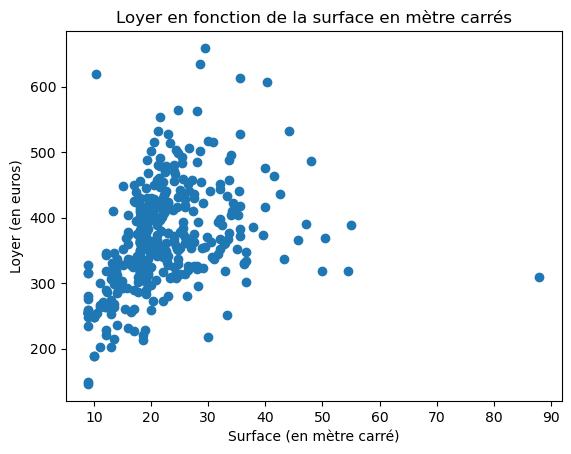

In [45]:
"""on regarde la répartition des loyers en fonction de la surface.
"""
plt.scatter(df2['Mean Surface'], df2['Mean Loyer'])
plt.title('Loyer en fonction de la surface en mètre carrés')
plt.xlabel('Surface (en mètre carré)')
plt.ylabel('Loyer (en euros)')
plt.show()

In [46]:
"""
On détailles les étapes pour définir la régression. 
Pour les régressions suivantes, on fera directement appel à la régression get_OLS_reg définie dans le fichier functions_fot_modelling.py .
"""

y = df2['Mean Loyer'] #on définit la variable expliquée

x = df2['Mean Surface'] #on définit la variable explicative

x = sm.add_constant(x) #on ajoute une constante au vecteur de prédiction

model = sm.OLS(y, x).fit() #on définit le modèle de régression linéaire

print(model.summary()) #on affiche le résumé de la régression

                            OLS Regression Results                            
Dep. Variable:             Mean Loyer   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     62.98
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           2.50e-14
Time:                        20:55:55   Log-Likelihood:                -2135.4
No. Observations:                 373   AIC:                             4275.
Df Residuals:                     371   BIC:                             4283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          291.3402     10.388     28.046   

In [47]:
#le R² est faible: la variable explicative (ici la surface moyenne) n'est pas très utile pour prédire le résultat. 
#La p-value indique que l'on rejette H0 à 1% et que le coefficient égal à 3.43 est significatif.

eval_env: 1


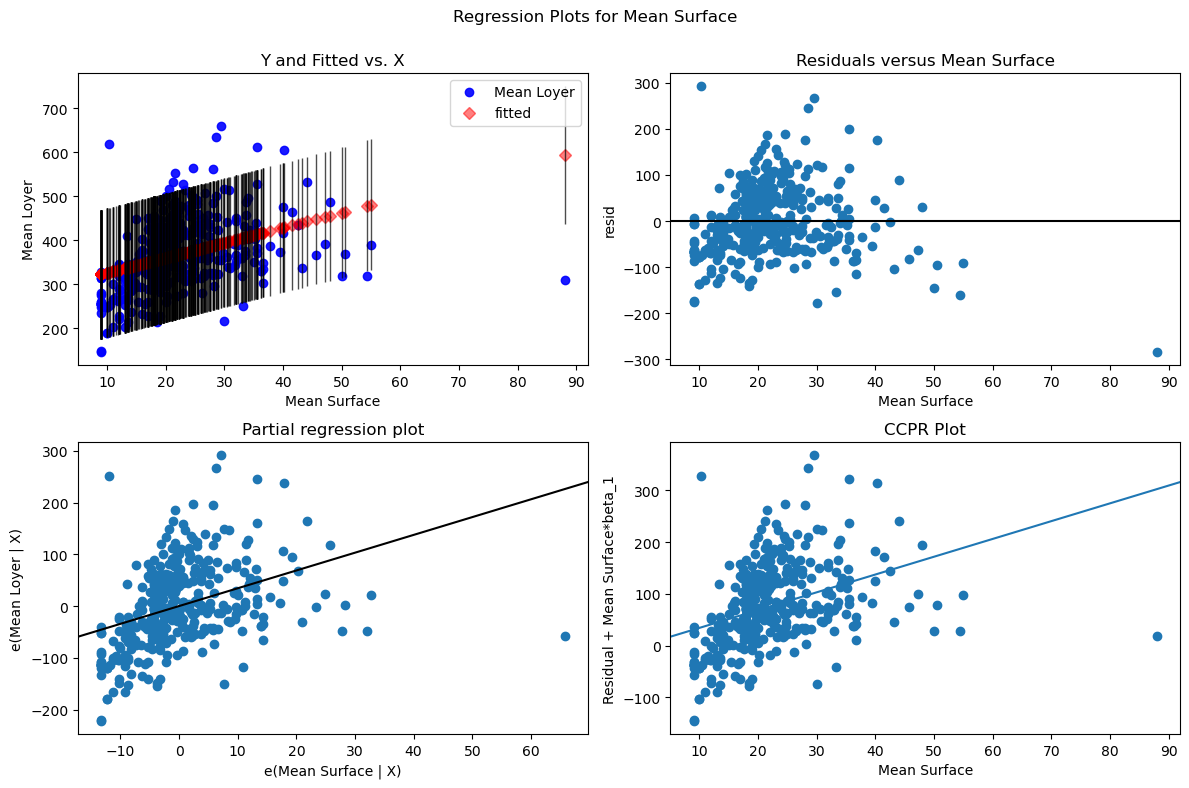

In [48]:
"""
On essaie de déterminer avec les graphiques suivants si l'hypothèse d'homoscedasticité des résidus est vérifiée.
Pour les régressions suivantes, on utilisera directement la fonction get_4_plots définie dans le fichier functions_for_modelling.py .
"""

fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'Mean Surface', fig=fig) #on représente graphiquement les résidus

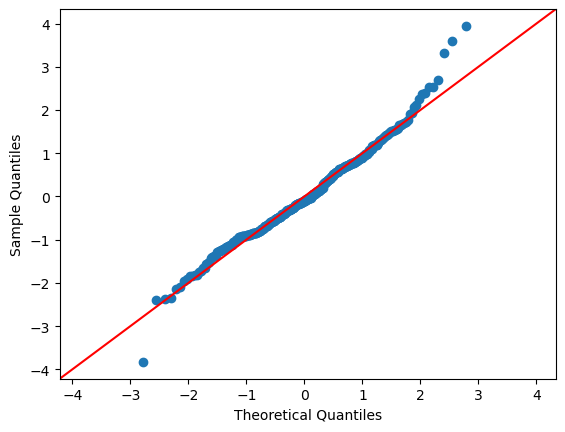

In [49]:
res = model.resid #on définit la variable res pour désigner les résidus

"""
On créé un Q-Q plot (Quantile-Quantile plot): ce type de graphe permet de voir si une variable a une distribution normale.
On compare la distribution des quantiles de l'échantillon à la distribution théorique (une droite à 45°) des quantiles d'une variable normalement distribuée.
Si les quantiles de l'échantillon des résidus (en bleu) sont sur la droite de 45° alors ils sont normalement distribués.

On affichera ensuite directement ce graphe lorsque l'on effectuera une régression avec la fonction get_OLS_reg du fichier functions_for_modelling.py.
"""
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 


#### https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab

In [50]:
""" 
On effectuer les tests de Breusch-Pagan et de White afin d'avoir une indication plus précise sur l'homoscédasticité ou non des résidus.
"""
#white_test = het_white(res,  model.exog)
bp_test=sm.stats.diagnostic.het_breuschpagan(res,x)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

print('breusch_pagan_results=',dict(zip(labels, bp_test)))
#print('white_results'==dict(zip(labels, white_test)))

breusch_pagan_results= {'LM Statistic': 16.327036010023487, 'LM-Test p-value': 5.329809539758669e-05, 'F-Statistic': 16.9828693825219, 'F-Test p-value': 4.6557866970443e-05}


In [51]:
#La p-value est inférieure à 0.05 donc d'après ce test, le modèle semble hétéroscedastique.
#Le seul inconvénient du test de Breusch-Pagan est qu'il peut donner une faible p-value même quand le modèle n'est pas hétéroscedastique.
#En effet, si le modèle est imparfait, généralement en raison d'un biais de variable omise, le test peut alors indiquer une p-value faible.

##### On se demande s'il ne vaut pas mieux considérer les variables 'Max Surface' et 'Max Loyer' ou 'Min Surface' et 'Min Loyer' pour avoir de meilleurs résultats.

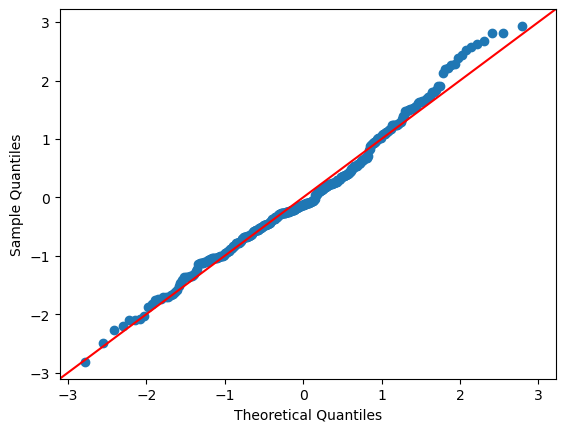

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Max Loyer   R-squared:                       0.180
 Model:                            OLS   Adj. R-squared:                  0.178
 Method:                 Least Squares   F-statistic:                     81.68
 Date:                Fri, 16 Dec 2022   Prob (F-statistic):           8.99e-18
 Time:                        20:55:56   Log-Likelihood:                -2256.1
 No. Observations:                 373   AIC:                             4516.
 Df Residuals:                     371   BIC:                             4524.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------------------------------

In [52]:
"""
On s'intèresse à la régression de la variable Max Loyer sur Max Surface.
"""
get_OLS_reg(df2['Max Surface'],df2['Max Loyer'])

In [53]:
get_bp_test(df2['Max Surface'],df2['Max Loyer']) #on effectue le test de Breusch-Pagan pour avoir une idée de l'homoscedasticité ou non des résidus. 
#on effectue ce test désormais directement avec la fonction get_bp_test.
#à nouveau la p-value est inférieure à 0,05 signe d'hétéroscedatisité des résidus et/ou d'un biais de variable omise.

('breusch_pagan_results=',
 {'LM Statistic': 53.89762985206857,
  'LM-Test p-value': 2.112123373365553e-13,
  'F-Statistic': 62.663341127323996,
  'F-Test p-value': 2.8669602765553046e-14})

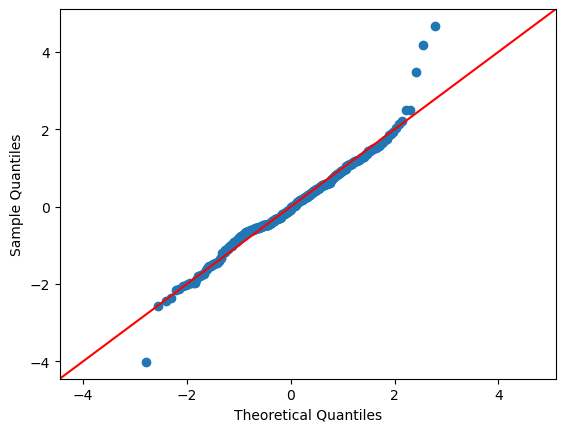

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Min Loyer   R-squared:                       0.108
 Model:                            OLS   Adj. R-squared:                  0.105
 Method:                 Least Squares   F-statistic:                     44.86
 Date:                Fri, 16 Dec 2022   Prob (F-statistic):           7.85e-11
 Time:                        20:55:56   Log-Likelihood:                -2118.1
 No. Observations:                 373   AIC:                             4240.
 Df Residuals:                     371   BIC:                             4248.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------------------------------

In [54]:
""" 
On s'intéresse enfin à la régression de Min Loyer sur Min Surface.
"""
get_OLS_reg(df2['Min Surface'],df2['Min Loyer'])

In [55]:
get_bp_test(df2['Min Surface'],df2['Min Loyer'])

('breusch_pagan_results=',
 {'LM Statistic': 19.514081306504345,
  'LM-Test p-value': 9.986082916850883e-06,
  'F-Statistic': 20.48094077261,
  'F-Test p-value': 8.12225926582192e-06})

##### Conclusion: la régression Max Loyer sur Max Surface est la meilleure des trois précédentes, mais si encore très imparfaite.

In [56]:
"""
On effectue une régression plus longue pour essayer d'identifier la présence d'un biais de sélection.
"""


"\nOn effectue une régression plus longue pour essayer d'identifier la présence d'un biais de sélection.\n"

### III.2.B Régression de la surface maximale sur le logarithme du loyer maximal

##### On choisit d'effectuer la régression sur le log du loyer maximal afin de voir si le fait que les loyers soient d'un facteur 10 plus élevé que les surfaces, "n'écrasent" pas ces dernières. 

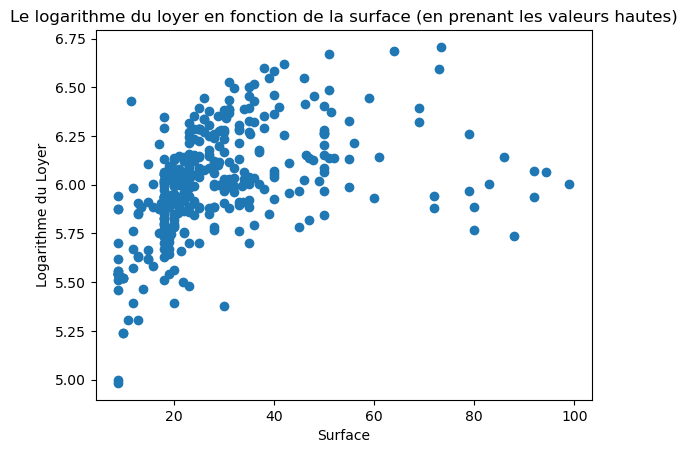

In [57]:
#on représente le prix au mètre carré des résidences crous en fonction du prix au mètre carré des résidences privées
plt.scatter(df2['Max Surface'], np.log(df2['Max Loyer']))
plt.title('Le logarithme du loyer en fonction de la surface (en prenant les valeurs hautes)')
plt.xlabel('Surface')
plt.ylabel('Logarithme du Loyer')
plt.show()

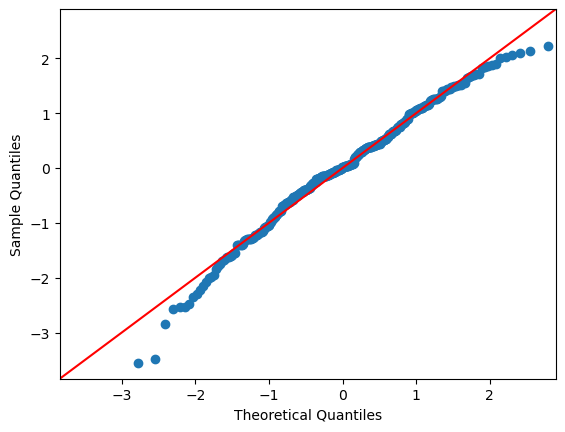

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Max Loyer   R-squared:                       0.185
 Model:                            OLS   Adj. R-squared:                  0.182
 Method:                 Least Squares   F-statistic:                     83.98
 Date:                Fri, 16 Dec 2022   Prob (F-statistic):           3.46e-18
 Time:                        20:55:56   Log-Likelihood:                -7.2897
 No. Observations:                 373   AIC:                             18.58
 Df Residuals:                     371   BIC:                             26.42
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------------------------------

In [58]:
Y_Log_Loyer= np.log(df2['Max Loyer'])
get_OLS_reg(df2['Max Surface'],np.log(df2['Max Loyer']))

In [59]:
get_bp_test(df2['Max Surface'],np.log(df2['Max Loyer']))

('breusch_pagan_results=',
 {'LM Statistic': 9.117183288226196,
  'LM-Test p-value': 0.0025321955559666283,
  'F-Statistic': 9.295506258024634,
  'F-Test p-value': 0.0024619941812158027})

## III.3 On cherche maintenant à prédire le prix au mètre carré des résidences crous

### III.3.A Régression linéaire du prix par mètre carré des résidences Crous ('Mean Loyer'/'Mean Surface') expliqué par le prix au m² des résidences privées

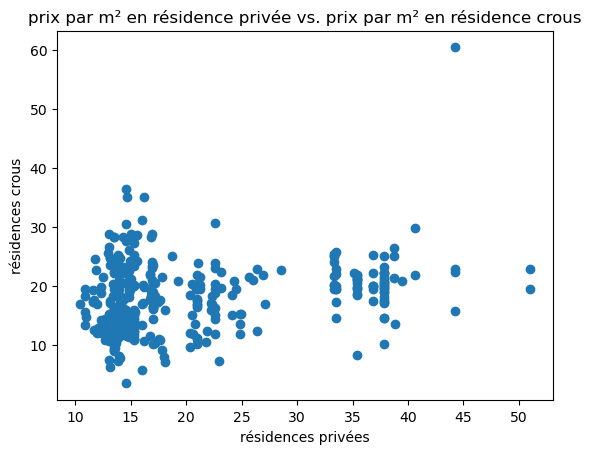

In [60]:
#on représente le prix au mètre carré des résidences crous en fonction du prix au mètre carré des résidences privées
plt.scatter(df2['upr.IPm2'], df2['Mean Loyer']/df2['Mean Surface'])
plt.title('prix par m² en résidence privée vs. prix par m² en résidence crous')
plt.xlabel('résidences privées')
plt.ylabel('résidences crous')
plt.show()

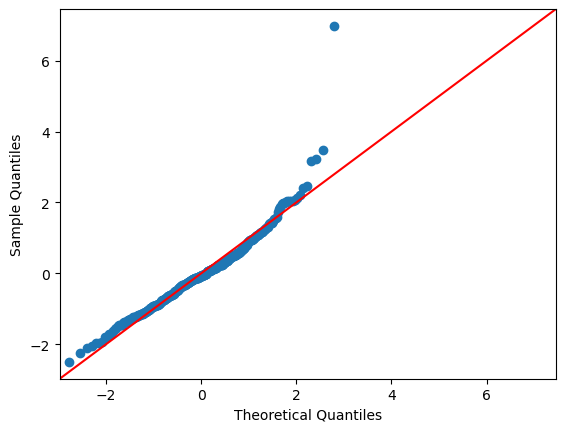

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.064
 Model:                            OLS   Adj. R-squared:                  0.062
 Method:                 Least Squares   F-statistic:                     25.51
 Date:                Fri, 16 Dec 2022   Prob (F-statistic):           6.92e-07
 Time:                        20:55:57   Log-Likelihood:                -1165.1
 No. Observations:                 373   AIC:                             2334.
 Df Residuals:                     371   BIC:                             2342.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [61]:
#on définit le modèle de régression linéaire de la même façon que précédemment, la fonction get_OLS_reg résume les commandes précédentes
get_OLS_reg(df2['upr.IPm2'],df2['Mean Loyer']/df2['Mean Surface'])

In [62]:
#le R² est très proche de zéro: comme on pouvait s'y attendre, le prix par mètre carré des loyers privés est peu pertinant pour expliquer le prix par mètre carré des loyers des résidences du crous

In [63]:
#regardons si l'hypothèse d'homoscedasticité des résidus est vérifiée ou non 

eval_env: 1


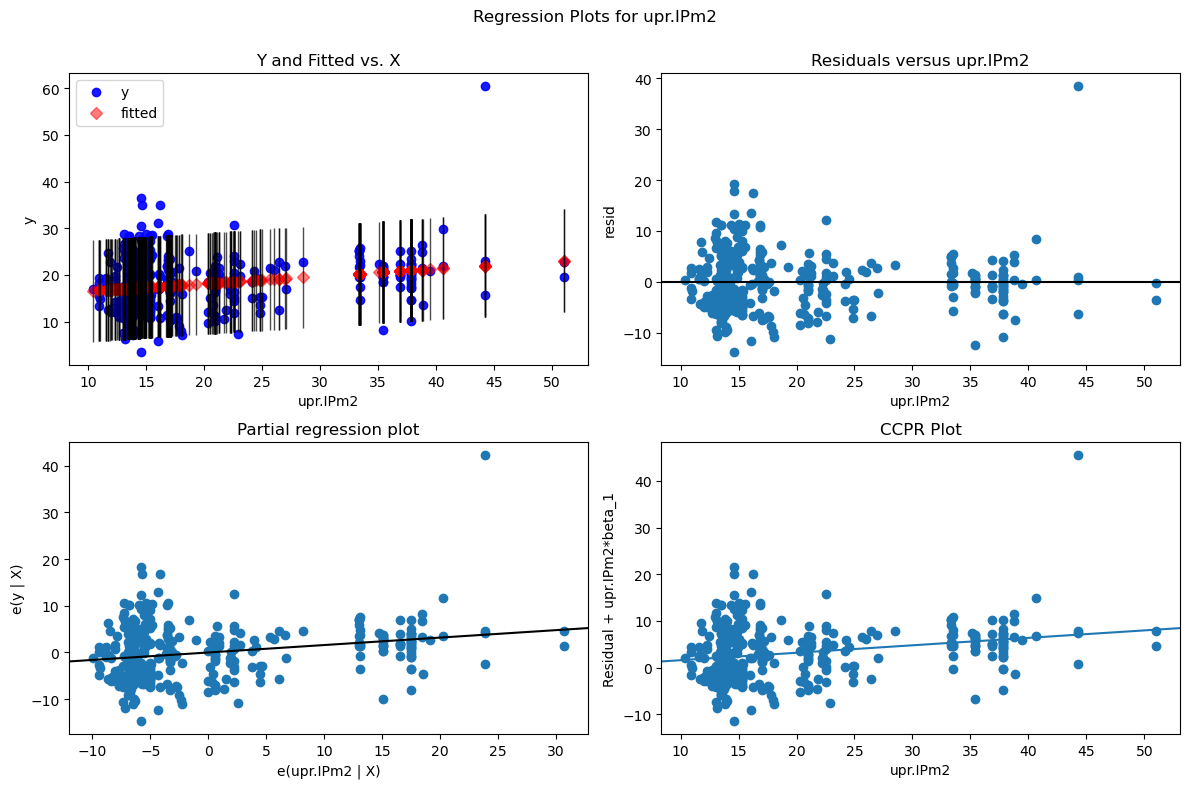

In [64]:
get_4_plots(df2['upr.IPm2'],df2['Mean Loyer']/df2['Mean Surface'])

### III.2.B Régression linéaire du prix au mètre carré des résidences crous sur le nombre d'étudiants total

In [67]:
df2['Nbstudents_total'].describe()

count       373.000000
mean      92742.745308
std      111873.041768
min           0.000000
25%       10029.000000
50%       36442.000000
75%       74156.000000
max      323129.000000
Name: Nbstudents_total, dtype: float64

In [66]:
""" 
On crée un nouveau dataframe df_students avec seulement les résidences avec plus de 1000 étudiants. 
On retire ainsi en grande majorité les valeurs manquantes et les valeurs non significatives qui viendraient fausser la régression.
"""
i = df2[df2['Nbstudents_total']<=1000].index.values
df_students = df2.drop(i,axis=0)
df_students['Nbstudents_total'].describe()

count       321.000000
mean     107766.492212
std      113689.237656
min        1682.000000
25%       26664.000000
50%       44394.000000
75%      269138.000000
max      323129.000000
Name: Nbstudents_total, dtype: float64

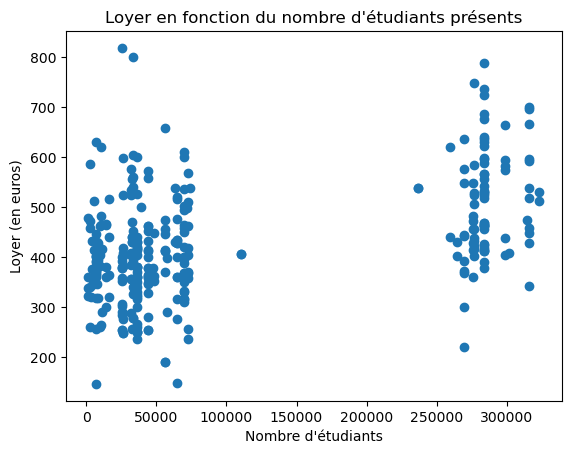

In [68]:
#on regarde le nombre d'étudiants payant un certain loyer
plt.scatter(df_students['Nbstudents_total'], df_students['Max Loyer']) 
plt.title("Loyer en fonction du nombre d'étudiants présents")
plt.xlabel("Nombre d'étudiants")
plt.ylabel('Loyer (en euros)')
plt.show()

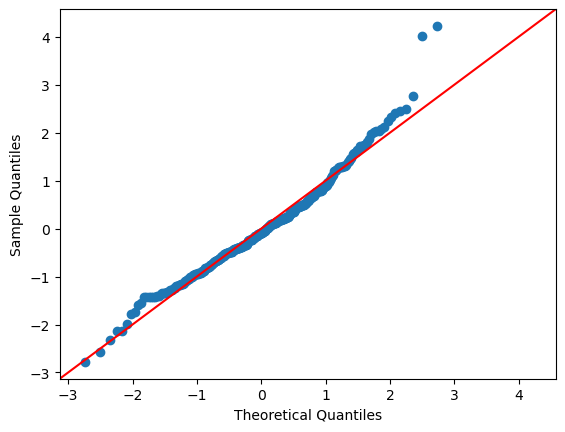

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Max Loyer   R-squared:                       0.207
 Model:                            OLS   Adj. R-squared:                  0.205
 Method:                 Least Squares   F-statistic:                     83.27
 Date:                Fri, 16 Dec 2022   Prob (F-statistic):           8.34e-18
 Time:                        21:11:15   Log-Likelihood:                -1937.5
 No. Observations:                 321   AIC:                             3879.
 Df Residuals:                     319   BIC:                             3886.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [69]:
get_OLS_reg(df_students['Nbstudents_total'],df_students['Max Loyer'])

### Lien très intéressant pour inclure 'robust to heteroscedasticity': https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html#statsmodels.regression.linear_model.RegressionResults.get_robustcov_results

In [73]:
results = sm.OLS(df_students['Nbstudents_total'],df_students['Max Loyer']).fit(cov_type='cluster', cov_kwds={'groups': df_students['Nbstudents_total']})
results.bse

Max Loyer    44.107204
dtype: float64

## III.4 L'élasticité prix du mètre carré dans les résidences crous

### III.4.A Régression linéaire 'courte' du log du prix par mètre carré dans les résidences crous sur le log du nombre d'étudiants 

In [ ]:
x= np.log(df_students['Nbstudents_total'])
y= np.log(df_students['Mean Loyer']/df_students['Mean Surface'])
get_OLS_reg(x,y)

In [ ]:
""" 
On effectuer le test de Breusch-Pagan avec la fonction get_bp_test.
"""

get_bp_test(x,y)

In [ ]:
#la p-value est inférieure à 0.05, il y a donc de l'hétéroscedasticité ou un biais de variable omise.

### III.3.B Régression longue du prix par mètre carré des résidences Crous ('Mean Loyer'/'Mean Surface') expliqué par le nombre d'étudiants total et le prix au mètre carré des résidences privées

In [ ]:
get_OLS_reg(df_students[['Nbstudents_total','upr.IPm2']],df_students['Mean Loyer']/df_students['Mean Surface'])

In [ ]:
get_bp_test(df_students[['Nbstudents_total','upr.IPm2']],df_students['Mean Loyer']/df_students['Mean Surface'])

In [ ]:
#on obtient presque le même graphique que pour la régression simple des prix au mètre carré des résidences crous sur les prix au mètre carré des résidences privées.
#le coefficient associé au nombre d'étudiants total est extrêmement faible.

## Regressions linéaires avec le module LinearRegression de sklearn

### On reprend la première régression effectuée plus haut: le loyer moyen expliqué par la surface moyenne

In [ ]:
get_sklearn_regression(df2['Mean Surface'],df2['Mean Loyer'],'Loyer_moyen','Surface_moyenne')

In [ ]:
var_explicatives = df2['Mean Surface']
YLoyer = df2['Mean Loyer']
#on transforme Y et X en matrices colonnes
YLoyer = np.array(YLoyer).reshape(-1,1)
var_explicatives = (np.array(var_explicatives).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(var_explicatives,YLoyer,test_size=0.3,train_size=0.7)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst)

In [ ]:
#On trouve un résultat légèrement différent de celui avec sm.OLS

In [ ]:

plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph


In [ ]:
#Deuxième essai: regression linéaire du min Loyer sur min surface 

In [ ]:
df2[['Min Loyer', 'Min Surface']].isnull().sum()

In [ ]:
X_min_surface = df2['Min Surface'] #la variable explicative
Y_min_Loyer = df2['Min Loyer']
#on transforme Y et X en array que l'on reformate
Y_min_Loyer = np.array(Y_min_Loyer).reshape(-1,1)
X_min_surface = (np.array(X_min_surface).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_min_surface,Y_min_Loyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
#avec la régression du min Loyer sur min Surface, on a un R² peu significatif

#### Regression linéaire du Loyer sur le nombre total d'étudiants

In [ ]:
X_Nbstudents = df_students['Nbstudents_total'] #la variable explicative
YLoyer = df_students['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_Nbstudents = (np.array(X_Nbstudents).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Nombre d'étudiants total (Training set)") # stating the title of the graph
 
plt.xlabel("Nb d'étudiants total") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [ ]:
#Regression linéaire du Loyer sur le LOG du nombre total d'étudiants

In [ ]:
X_log_Nbstudents = np.log(df_students['Nbstudents_total']) #la variable explicative
YLoyer = df_students['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_log_Nbstudents = (np.array(X_log_Nbstudents).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_log_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen en fonction du logarithme du nombre d'étudiants total (Training set)") # stating the title of the graph
 
plt.xlabel("Logarithme du nombre d'étudiants total") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [ ]:
#régression linéaire du 